# Introduction

Here, we show some various use cases of the pre-computed ChromBPNet-related analysis products (i.e. accessibility predictions, contribution scores, and motif istances). Then, we show how to load the trained cell type-specific ChromBPNet model to make new predictions.

We make heavy use of the [`tangermeme`](https://tangermeme.readthedocs.io/en/latest/index.html) and [`bpnetlite`](https://github.com/jmschrei/bpnet-lite) packages by Jacob Schreiber for working with trained models
in pytorch. Please see the `tangermeme` documentation for more ways to use ChromBPNet models.

See our more detailed documentation on analysis products and data types [here](https://github.com/GreenleafLab/HDMA/blob/main/DATA.md).

_Run in the `tangermeme` environment on lab cluster._

# Setup

In [3]:
%load_ext autoreload
%autoreload 2

# deal with matplotlib plots
%matplotlib inline

# display all outputs in a cell
get_ipython().ast_node_interactivity = 'all'

from IPython.display import display, HTML

In [113]:
# misc
import sys
import os
import numpy as np
import random
from tqdm import tqdm
import pandas as pd

# io
import h5py
from pyfaidx import Fasta

# ML
import bpnetlite
from bpnetlite import ChromBPNet
from bpnetlite import BPNet
from bpnetlite.bpnet import CountWrapper
from bpnetlite.attribute import deep_lift_shap

import torch


# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn; seaborn.set_style('white')
import matplotlib.ticker as ticker
import plotnine as pn
import logomaker
import tangermeme
from tangermeme.plot import plot_logo

from tangermeme.utils import characters
from tangermeme.utils import one_hot_encode
from tangermeme import io


print(f"numpy version: {np.__version__}")
print(f"tangermeme version: {tangermeme.__version__}")
print(f"bpnetlite version: {bpnetlite.__version__}")
print(f"torch version: {torch.__version__}")

# os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['CUDA_VISIBLE_DEVICES']='MIG-40f43250-998e-586a-ac37-d6520e92590f'

torch.manual_seed(100)

# editable text in PDFs
# https://stackoverflow.com/a/54111532
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

numpy version: 2.0.2
tangermeme version: 0.4.3
bpnetlite version: 0.8.1
torch version: 2.3.1+cu121


Check we have GPU access:

In [5]:
torch.cuda.device_count()

1

In [6]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

torch.cuda.is_available()

t1 = torch.randn(1,2).to(dev)
t1
t1.device

device(type='cuda')

True

tensor([[ 0.3607, -0.2859]], device='cuda:0')

device(type='cuda', index=0)

# Variables

ChromBPNet models take in sequences of length `INPUTLEN` (2,114 bp) and returns accessibility in the central `OUTPUTLEN` (1,000 bp) region of the input.

Thus, we define some helpful variables below. We will use these to compute relative
coordinates in some cases for plotting tracks which are genomically aligned.

In [7]:
INPUTLEN = 2114
OUTPUTLEN = 1000
MIDPOINT = INPUTLEN // 2
SHIFT_REL_INPUT = np.int64((2114 - 1000) / 2)
SHIFT_REL_INPUT

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

LOGO_ALPHABET = 'ACGT'

# finemo colorscheme
LOGO_COLORS = {"A": '#109648', "C": '#255C99', "G": '#F7B32B', "T": '#D62839'}

# logomaker colorscheme
LOGO_COLORS2= {
        'G': [1, .65, 0],
        'T': [1, 0, 0],
        'C': [0, 0, 1],
        'A': [0, .5, 0]
    }

CHAR_IGNORE = ['QWERYUIOPSDFHJKLZXVBNM']

np.int64(557)

# Paths

In [8]:
with open("../DURGA_DIRS.txt", 'r') as f:
	proj_in = f.readline().strip()
	proj_out = f.readline().strip()

with open("../AK_PROJ_DIR.txt", 'r') as f:
    kundaje_dir = f.readline().strip()

In [9]:
genome_fa = os.path.join(kundaje_dir, "refs/hg38/chrombpnet/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [10]:
hg38 = Fasta(genome_fa)

# Load and visualize pre-computed predictions and contribution scores

We provide peaks used for model training, accessibility predictions, and per-nucleotide contribution scores for each
peak in every cell type. We can load those outputs to inspect predicted accessibility
and contribution scores at peaks of interest.

In this section, we point to internal local paths, but each of these files
can be obtained from our data repositories on Zenodo.

We use the the `extract_loci` function from `tangermeme`, which loads the peaks as one-hot encoded sequences,
along with the outputs (predictions, contribution scores) for each sequence.

In [13]:
# path to bed file for peaks
peaks_bed = os.path.join(proj_in, "00-inputs/chrombpnet_peaks/Brain_c0__peaks_bpnet.narrowPeak.gz")

# path to bigwig with bias-corrected predictions
preds_bw    = os.path.join(proj_in, "01-models/predictions/bias_corrected/Brain_c10_avg_chrombpnet_nobias.bw")

# path to bigwig with contribution scores
contribs_bw = os.path.join(proj_in, "01-models/contribs/bias_Heart_c0_thresh0.4/Brain_c0/average_shaps.counts.bw")

X_peaks, y_peaks = io.extract_loci(peaks_bed, genome_fa,
								   signals = [preds_bw, contribs_bw],
								   ignore = CHAR_IGNORE)

The `X_peaks` variable contains the one-hot encoded sequences, with shape `(num_peaks, 4, INPUTLEN)`.

In [15]:
X_peaks.shape
X_peaks[0]

torch.Size([117140, 4, 2114])

tensor([[0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int8)

The `y_peaks` variable contains scalar values for predicted accessibility and contribution
score at each nucleotide, with shape `(num_peaks, 2, OUTPUTLEN)`.

In [16]:
y_peaks.shape
y_peaks[0]

torch.Size([117140, 2, 1000])

tensor([[ 0.0043,  0.0043,  0.0043,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0009, -0.0006, -0.0006]])

We also load in the peak coordinates:

In [17]:
X_peaks_coords = pd.read_csv(peaks_bed, sep='\t', header=None, names = NARROWPEAK_SCHEMA)
X_peaks_coords.head()

,chr,start,end,1,2,3,4,5,6,summit
0,chr1,9641,10641,.,.,.,.,.,.,500
1,chr1,9905,10905,.,.,.,.,.,.,500
2,chr1,180976,181976,.,.,.,.,.,.,500
3,chr1,777919,778919,.,.,.,.,.,.,500
4,chr1,778224,779224,.,.,.,.,.,.,500


We also load in the contribution scores in h5 format, which will allow us
to plot them as sequence logos.

In [18]:
# load contribution scores
y_contribs = h5py.File(proj_in + "01-models/contribs/bias_Heart_c0_thresh0.4/Brain_c0/average_shaps.counts.h5", "r")
y_contribs.keys()

<KeysViewHDF5 ['projected_shap', 'raw', 'shap']>

We also load in the hits _aka_ predictive motif instances:

In [19]:
instances = pd.read_csv(proj_out + "03-chrombpnet/02-compendium/hits_unified_motifs/reconciled_per_celltype_peaks/Brain_c0/counts_v0.23_a0.8_all/hits_unique.reconciled.annotated.tsv.gz", sep = "\t")
instances.head()

# print column names
instances.columns

,seqnames,start,end,width,strand,start_untrimmed,end_untrimmed,motif_name,source,hit_coefficient,...,motif_name_unlabeled,pattern_class,distToGeneStart,nearestGene,peakType,distToTSS,nearestTSS,GC,N,distToPeakSummit
0,chr1,10175,10180,5,-,10158,10188,456|ZEB/SNAI,1,0.961838,...,neg_patterns.neg.Average_12__merged_pattern_0,neg_patterns,1690,DDX11L1,Promoter,1690,ENST00000456328.2,0.4000,0,36
1,chr1,10503,10509,6,-,10497,10527,456|ZEB/SNAI,2,0.985665,...,neg_patterns.neg.Average_12__merged_pattern_1,neg_patterns,1362,DDX11L1,Promoter,1362,ENST00000456328.2,0.6667,0,100
2,chr1,10555,10561,6,+,10545,10575,4|BCL11A/Brepressive,2,0.432991,...,neg_patterns.neg.Thymus__Average_6__merged_pat...,neg_patterns,1310,DDX11L1,Promoter,1310,ENST00000456328.2,0.5000,0,152
3,chr1,10566,10575,9,+,10560,10590,436|SP/KLF,2,6.695272,...,pos_patterns.pos.Average_212__merged_pattern_0,pos_patterns,1297,DDX11L1,Promoter,1297,ENST00000456328.2,0.8889,0,165
4,chr1,10642,10652,10,-,10629,10659,400|NRF1,2,3.583460,...,pos_patterns.pos.Average_159__merged_pattern_0,pos_patterns,1221,DDX11L1,Promoter,1221,ENST00000456328.2,0.9000,0,241


Index(['seqnames', 'start', 'end', 'width', 'strand', 'start_untrimmed',
       'end_untrimmed', 'motif_name', 'source', 'hit_coefficient',
       'hit_correlation', 'hit_importance', 'peak_name', 'peak_id',
       'motif_name_unlabeled', 'pattern_class', 'distToGeneStart',
       'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'N',
       'distToPeakSummit'],
      dtype='object')

The extracted sequences are length 2114, because of the default `in_window` parameter of `tangermeme.io.extract_loci`,
and matches the input length of ChromBPNet.

Therefore, the start of the 1,000 bp peak within the 2,114 bp window should be position (2114 - 1000) / 2 = 557. We can confirm that the next 10 bases of the one-hot encoded sequence match what we see at the beginning of the peak in the reference:

In [20]:
# taking the 31861th peak:
i = 31861

# reference squence
hg38[X_peaks_coords.iloc[i]['chr']][X_peaks_coords.iloc[i]['start']:X_peaks_coords.iloc[i]['start'] + 10].seq

# one-hot encoded sequence converted back to nucleotides
characters(X_peaks[i][:, 557:567])

'GCCTGCAAGG'

'GCCTGCAAGG'

Now we can plot the predictions and contribution scores for a peak of interest near FOXG1.

Let's also get the motif instances in this region:

In [21]:
instances_local = instances[instances['peak_id']==i]
instances_local

# convert these to relative coordinates for annotation
annotations = instances_local[['start', 'end', 'motif_name', 'hit_coefficient', 'strand']]
annotations.loc[:, 'start'] = annotations['start'] - X_peaks_coords.iloc[i]['start'] + SHIFT_REL_INPUT
annotations.loc[:, 'end'] = annotations['end'] - X_peaks_coords.iloc[i]['start'] + SHIFT_REL_INPUT

# rename motif_name to name
annotations = annotations.rename(columns={'hit_coefficient': 'score'})

# reorder the columns
annotations = annotations[['motif_name', 'start', 'end', 'strand', 'score']]

,seqnames,start,end,width,strand,start_untrimmed,end_untrimmed,motif_name,source,hit_coefficient,...,motif_name_unlabeled,pattern_class,distToGeneStart,nearestGene,peakType,distToTSS,nearestTSS,GC,N,distToPeakSummit
545198,chr14,28766432,28766440,8,+,28766420,28766450,157|ETS:ELF/ETV#1,1,0.134989,...,pos_patterns.pos.Average_306__merged_pattern_0,pos_patterns,350,FOXG1,Promoter,350,ENST00000313071.7,0.5000,0,293
545199,chr14,28766664,28766671,7,-,28766650,28766680,367|NFY,2,89.228280,...,pos_patterns.pos.Average_276__merged_pattern_1,pos_patterns,118,FOXG1,Promoter,118,ENST00000313071.7,0.5714,0,61
545200,chr14,28766709,28766716,7,-,28766695,28766725,367|NFY,2,69.797290,...,pos_patterns.pos.Average_276__merged_pattern_1,pos_patterns,73,FOXG1,Promoter,73,ENST00000313071.7,0.4286,0,16


We highlight a region which we will zoom into, and we see two nice NFY sites standing out.

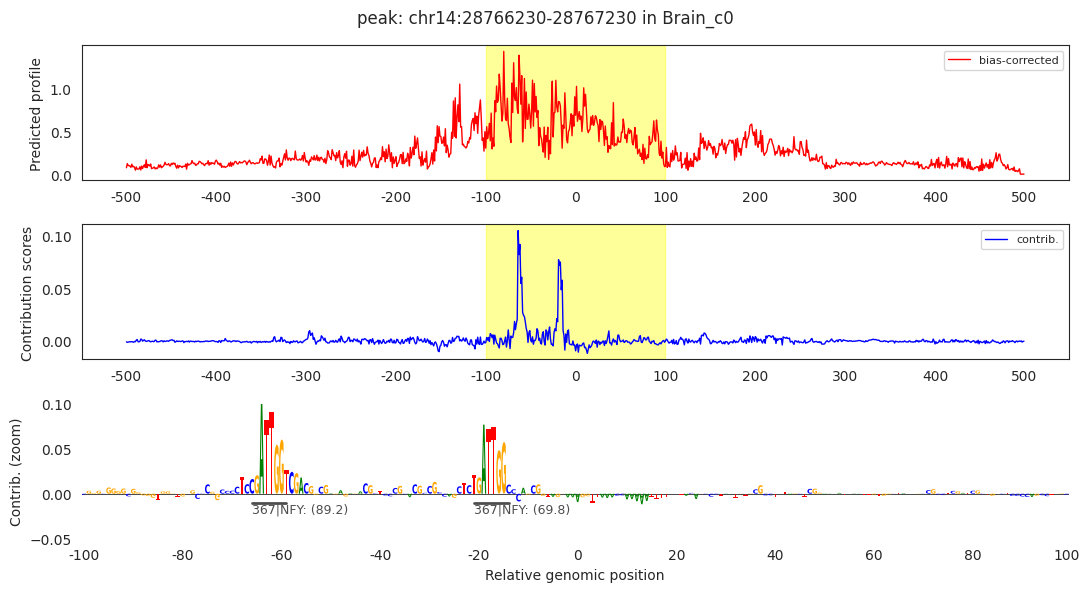

In [23]:
fig, ax = plt.subplots(3, 1, figsize = (11, 6))

# plot the predicted profile for the top hit
ax[0].plot(y_peaks[i][0], linewidth=1, label = "bias-corrected", color = 'red')
ax[0].set_ylabel("Predicted profile")
ax[0].legend(fontsize = 8)
ax[0].axvspan(400, 600, alpha=0.4, color='yellow')
ax[0].set_xticks(ticks = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999], labels = [-500, -400, -300, -200, -100, 0, +100, +200, +300, +400, +500])

# contribs
ax[1].plot(y_peaks[i][1], linewidth=1, label = "contrib.", color = "blue")
ax[1].set_ylabel("Contribution scores")
ax[1].legend(fontsize = 8)
ax[1].axvspan(400, 600, alpha=0.4, color='yellow')
ax[1].set_xticks(ticks = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999], labels = [-500, -400, -300, -200, -100, 0, +100, +200, +300, +400, +500])

# plot the contrbs in the central 200 bp as a sequence logo
tangermeme.plot.plot_logo(np.float64(y_contribs['projected_shap']['seq'][i]),
						  start = SHIFT_REL_INPUT + 400, end = SHIFT_REL_INPUT + 600, ax=ax[2],
						  # add in the annotations from the motif instances
						  annotations = annotations)
ax[2].set_ylabel("Contrib. (zoom)")
ax[2].set_ylim(-0.05, 0.1)
ax[2].set_xticks(
	ticks = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 199],
	labels = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100])

# put a title at the very top
plt.xlabel("Relative genomic position")
plt.suptitle("peak: " + X_peaks_coords.iloc[i]['chr'] + ":" + str(X_peaks_coords.iloc[i]['start']) + "-" + str(X_peaks_coords.iloc[i]['end']) + " in Brain_c0", fontsize = 12)
plt.tight_layout()
plt.show();

This matches what we see in [the genome browser](https://epigenomegateway.wustl.edu/browser2022/?blob=3Vjvb9s2EP1XBPZLB9iKLSd15m9tVswF0qRIvK7AUAgn8SxxpUiVpOw4Rv73HiX5R9xsc9t4wwIDhijevbv3.Hy2tWQZKl3gBRTIRizPBqesw2YC52.UQzMDyUZLZh0Yx0ZRFPX6w8Hx6UmHoeKrG8cnp4O7DnMG0k.Wjf5YMtWgXVUSDcG5RemXpl1KSJBg19u6dEIrylzubBFoZfySggp0wMGBj5r4SsE9VAoV9holpg6psSlIix02FRIvkz8bBL_w7X3capWuhZ3gDZFrUxwtzrSaiowqESqUYnv5uUKzeK14qYWipOXdXWdN1.D0V1S4IUzSIiilHXiCW8w3kQ9wX23uxX6nxH8mQ6f10cpDW7K8fXnxOrZ1T3E_PN5DHp8RNBm0EcyarAekeijwqcj26ipOe6MAb1JBXWqzCBRWhgQI.sFlYoPnVmQKZFB26UNa4U8bXRORzaniRs_vgNoSG7LMYAYO36LLNclDsn.gkFRLbWj1rHc2jIZnP1JvfWa5c6UdHR3lVQGqy3HWLSpJnRTYBSfBhnYQQgG3WsHchqkujprDOHplQCiqur4IS8IOm0JhMt8xQyorS.Pt73utOdIU9EfFGqTYo9L9e2Zq9X7YRDbX80s1rpJzDf.ytTzZvEqoyG9X54G_2tNe7wxyUbP4Pk9t5x_MSJsiB3BPDLMsTnOji6RU6GKlE0H5j.Cjsmm71uSp..h6_PJd8DzVlXJ2az7xhbL4ec9j3sXYw0_fDvuIDoIZGsgwtjmUPsIXeAzfcMTSY8YN5K53Wk2f0AxCoCY286ceJnvNhTbxcIOnLnCIoROXHjquR06owBg998XC7PbHx06ryv2B0wzPJ.KYsXD006JSYiqQdwwS.ZR65J2vBtD.ZtoDcw.fgZzDwv5iYH7e1HSmIm2.tl99J_pmR_5jlwcxa05V47ZoO.jiWS.MBjH0wtMYpAw3rYSk.WP4eLvo_9XOBLsSYYKmaCuRc8hH10iz_f76ff1nnOMNG3X7bXfnSP8b.O.Cu5yN.lGvw5JKcYlvvOk4RCc_Y6_XjfqDabffn_a6MB0Ou8nJi3TIjwcv0gSIMelEsgiVXcBMkGu9FxtjrnfeX62ZS1joynNimdRJ.1iglMLR.V2LW9KfmnCQUMNjBI5mjCLLKWF9e0LvzohyvUHqbFBX_.a1_6oUnsaz.uRzIblBVT9WaGMIzqJbh0V_HbaKgbKky9UMoRq2fvBA_i61aozVhKCCROKZ1JYia.Z3H.lF8mpDnOqjoVVODKRn0Z4VB_NpkqOHb5K.AA--) at this locus:

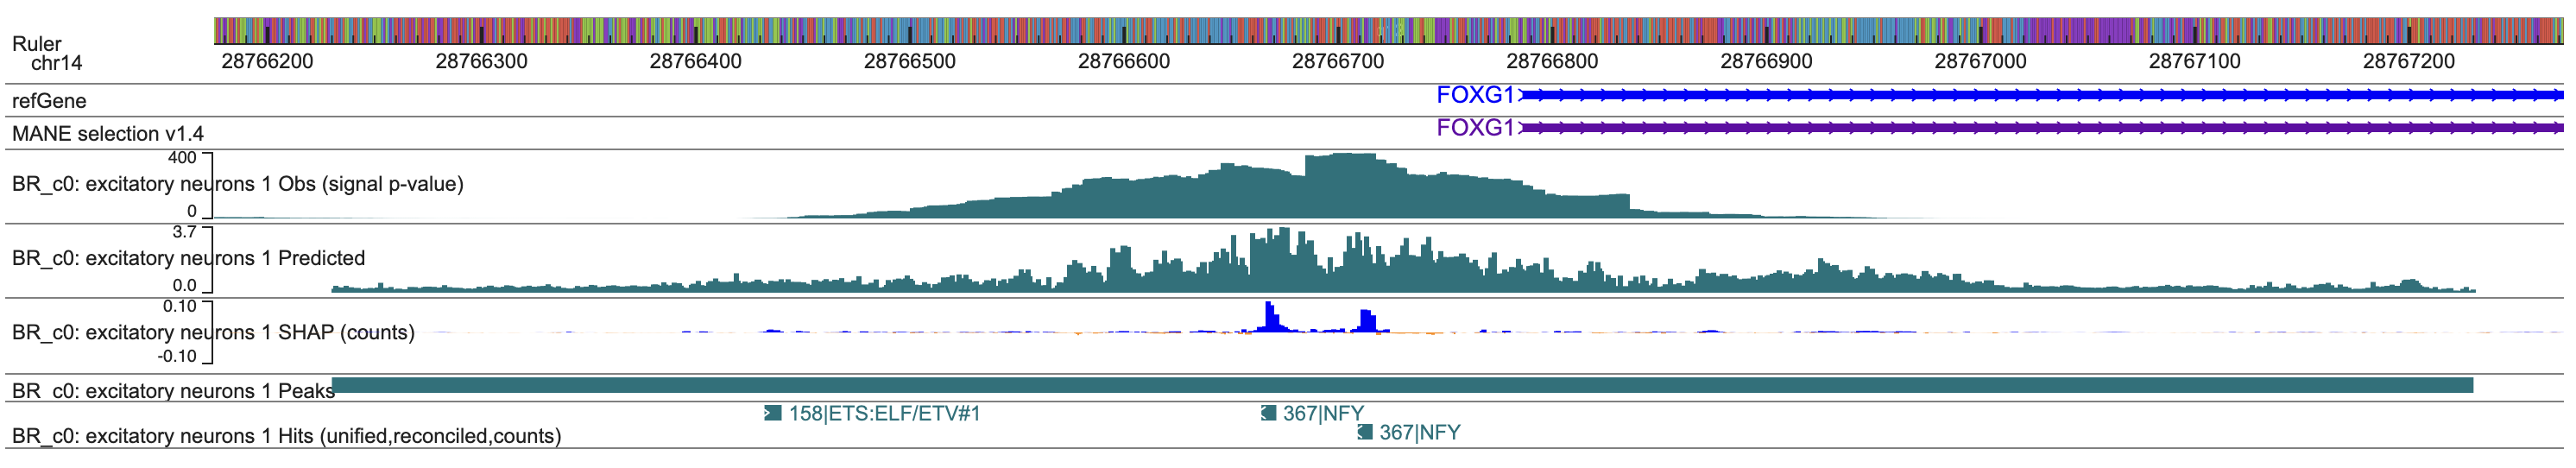

# Load a model

We can download the tar file of trained models for each cell type from Zenodo:

- part 1: https://doi.org/10.5281/zenodo.15048277
- part 2: https://doi.org/10.5281/zenodo.15200486

And then extract the models:

```bash
$ tar -xvf Brain_c0.gz
x Brain_c0/
x Brain_c0/Brain_c0__fold_0__bias_model_scaled.h5
x Brain_c0/Brain_c0__fold_2__chrombpnet.h5
x Brain_c0/Brain_c0__fold_4__bias_model_scaled.h5
x Brain_c0/Brain_c0__fold_4__chrombpnet.h5
x Brain_c0/Brain_c0__fold_3__bias_model_scaled.h5
x Brain_c0/Brain_c0__fold_1__chrombpnet.h5
x Brain_c0/Brain_c0__fold_0__chrombpnet_nobias.h5
x Brain_c0/Brain_c0__fold_0__chrombpnet.h5
x Brain_c0/Brain_c0__fold_3__chrombpnet.h5
x Brain_c0/Brain_c0__fold_1__bias_model_scaled.h5
x Brain_c0/Brain_c0__fold_2__chrombpnet_nobias.h5
x Brain_c0/Brain_c0__fold_4__chrombpnet_nobias.h5
x Brain_c0/Brain_c0__fold_2__bias_model_scaled.h5
x Brain_c0/Brain_c0__fold_1__chrombpnet_nobias.h5
x Brain_c0/Brain_c0__fold_3__chrombpnet_nobias.h5
$ ls Brain_c0
Brain_c0__fold_0__bias_model_scaled.h5 Brain_c0__fold_2__chrombpnet.h5
Brain_c0__fold_0__chrombpnet_nobias.h5 Brain_c0__fold_3__bias_model_scaled.h5
Brain_c0__fold_0__chrombpnet.h5        Brain_c0__fold_3__chrombpnet_nobias.h5
Brain_c0__fold_1__bias_model_scaled.h5 Brain_c0__fold_3__chrombpnet.h5
Brain_c0__fold_1__chrombpnet_nobias.h5 Brain_c0__fold_4__bias_model_scaled.h5
Brain_c0__fold_1__chrombpnet.h5        Brain_c0__fold_4__chrombpnet_nobias.h5
Brain_c0__fold_2__bias_model_scaled.h5 Brain_c0__fold_4__chrombpnet.h5
Brain_c0__fold_2__chrombpnet_nobias.h5
```

Generally, we will want to use `*_chrombpnet_nobias.h5` models for all downstream work,
which produces bias-corrected model predictions. See our documentation [here](https://github.com/GreenleafLab/HDMA/blob/main/DATA.md#trained-chrombpnet-models) for more details.

To load a pre-trained ChromBPNet model, we can use the `BPNet` class from the `bpnetlite` package.
The ChromBPNet models return two outputs: the profile predictions a vector of logits over 1,000 bp,
and the log counts as a scalar value.

To convert the logits to accessibility profiles, we softmax the logits and scale
by the exponentiated log counts. Throughout the code, we use a pytorch wrapper implemented
in [`code/03-chrombpnet/tangermeme_utils/wrappers.py`](https://github.com/GreenleafLab/HDMA/blob/main/code/03-chrombpnet/tangermeme_utils/wrappers.py), but for convenience, we show
the wrapper here:

```python

class ChromBPNetWrapper(torch.nn.Module):
	"""A wrapper class that returns counts and transformed profiles
	from a bias-corrected ChromBPNet model.

	This class takes in a trained model, specifically expecting a BPNet model
	from a trained bias-corrected ChromBPNet model (i.e. `chrombpnet_nobias.h5`),
	_not_ the full accessibility model.

	It returns outputs the same shape as the BPNet model, but with the predicted
	profile logits softmaxed and scaled by the exponent of the predicted counts.
	This is for convenience when plotting, since in e.g. bigwigs, we are inspecting
	the scaled profile, not the unnormalized logits.

	Parameters
	----------
	model: torch.nn.Module
		A torch model to be wrapped.
	"""

	def __init__(self, model):
		super().__init__()
		self.model = model
	
	def forward(self, X):
        
		y = self.model(X)

		# predicted profile logits
		y_profile = y[0]

		# predicted log counts
		y_counts = y[1]
              
		# softmax the logits to get profile probabilities
		y_profile = torch.nn.functional.softmax(y_profile, dim = -1)

		# scale the profile by the exponentiated predicted ln(counts)
		y_profile = y_profile * torch.exp(y_counts).unsqueeze(2)

		return y_profile, y_counts

```

First, we load the model for one fold:

In [24]:
brain_model = ChromBPNetWrapper(BPNet.from_chrombpnet(
	filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/Brain_c0/fold_0/models/chrombpnet_nobias.h5")))

# Predict and interpret for a region of interest

Now we can run a forward pass through the model to get predicted outputs.
Let's use a different peak region, near the SLC17A7 gene.

Check out the tutorial on prediction from `tangermeme` for more details:
https://tangermeme.readthedocs.io/en/latest/tutorials/Tutorial_A3_Deep_LIFT_SHAP.html

We use "contribution", "attribution", "interpretation", and "importance" interchangeably.

In [25]:
j = 54288
y_1 = tangermeme.predict.predict(brain_model, X_peaks[j].unsqueeze(0).float())

As expected, the model returns two values, one for each model head: the profiles, and the ocunts. Since we used our model wrapper, the profile values are already scaled by the exponentiated log counts and represent predicted accessibility profiles. The counts are predicted log counts.

In [26]:
len(y_1)
y_1[0].shape
y_1[1].shape

2

torch.Size([1, 1, 1000])

torch.Size([1, 1])

Next we run model interpretation. Note that for convenience in calculating the attributions, we need to use the `CountWrapper` class from `bpnet-lite` to get the counts predictions only, since the attributions algorithm (DeepLIFT/SHAP) can only explain a single output at a time.

We also use `bpnetlite.attribute.deep_lift_shap` as our attribution/model interpretation
function, which automatically registers the layers that are necessary for using Chrom
BPNet models.

Check out the `tangermeme` tutorial on interpretation for more details:
https://tangermeme.readthedocs.io/en/latest/tutorials/Tutorial_A3_Deep_LIFT_SHAP.html

In [27]:
brain_model_counts = CountWrapper(BPNet.from_chrombpnet(
	filename=os.path.join(proj_in, f"01-models/models/bias_Heart_c0_thresh0.4/Brain_c0/fold_0/models/chrombpnet_nobias.h5")))

# we need to pass a batch of shape (n_seqs, 4, 1000), so we add an extra dimension here 
# since we're just passing in a single sequence
attr_1 = deep_lift_shap(brain_model_counts, X_peaks[j].unsqueeze(0).float(), random_state=0, print_convergence_deltas=True)

tensor([4.5419e-04, 1.3351e-05, 2.0528e-04, 1.1563e-04, 1.2207e-04, 1.8907e-04,
        2.4796e-05, 2.8729e-04, 3.2043e-04, 1.3494e-04, 1.0395e-04, 2.5105e-04,
        2.1458e-05, 9.5367e-06, 3.8862e-04, 1.4544e-04, 1.8716e-04, 2.6727e-04,
        1.1206e-04, 2.2173e-04], device='cuda:0', grad_fn=<AbsBackward0>)


As expected, every nucleotide in the input region (`INPUTLEN`, 2,114 bp) is assigned a contirubtion score to the output, therefore the output is of shape `(num_peaks, 4, INPUTLEN)`.

In [33]:
attr_1.shape
attr_1.sum(axis = 1).shape

torch.Size([1, 4, 2114])

torch.Size([1, 2114])

We can make a similar plot as above, with the newly calculated predictions and contribution scores.

In [48]:
y_1[0].squeeze(0).T.shape
attr_1.sum(axis = 1).T.shape
attr_1.shape

torch.Size([1000, 1])

torch.Size([2114, 1])

torch.Size([1, 4, 2114])

In this case, we can see a few sites popping up in the contribution tracks, including a BHLH site (E-box) in the center (CAGATG), which contributes the most to accessibility in this region.

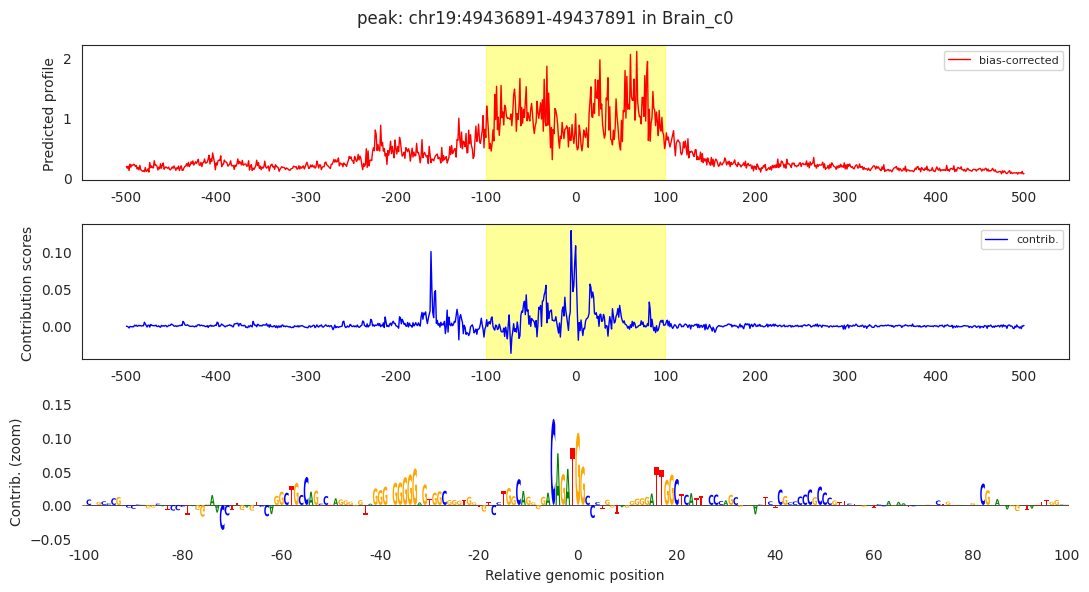

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (11, 6))

# plot the predicted profile for the top hit, in the shape (1000, 1)
ax[0].plot(y_1[0].squeeze(0).T, linewidth=1, label = "bias-corrected", color = 'red')
ax[0].set_ylabel("Predicted profile")
ax[0].legend(fontsize = 8)
ax[0].axvspan(400, 600, alpha=0.4, color='yellow')
ax[0].set_xticks(ticks = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999], labels = [-500, -400, -300, -200, -100, 0, +100, +200, +300, +400, +500])

# contribs - the central 1,000 bp only to align with the output window
ax[1].plot(attr_1.sum(axis = 1).T[SHIFT_REL_INPUT:(SHIFT_REL_INPUT+1000), :], linewidth=1, label = "contrib.", color = "blue")
ax[1].set_ylabel("Contribution scores")
ax[1].legend(fontsize = 8)
ax[1].axvspan(400, 600, alpha=0.4, color='yellow')
ax[1].set_xticks(ticks = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999], labels = [-500, -400, -300, -200, -100, 0, +100, +200, +300, +400, +500])

# plot the contrbs in the central 200 bp as a sequence logo
tangermeme.plot.plot_logo(np.float64(attr_1.squeeze(0)),
						  start = SHIFT_REL_INPUT + 400, end = SHIFT_REL_INPUT + 600, ax=ax[2])
ax[2].set_ylabel("Contrib. (zoom)")
ax[2].set_ylim(-0.05, 0.15)
ax[2].set_xticks(
	ticks = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 199],
	labels = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100])

# put a title at the very top
plt.xlabel("Relative genomic position")
plt.suptitle("peak: " + X_peaks_coords.iloc[j]['chr'] + ":" + str(X_peaks_coords.iloc[j]['start']) + "-" + str(X_peaks_coords.iloc[j]['end']) + " in Brain_c0", fontsize = 12)
plt.tight_layout()
plt.show();

# Predict the effect of a variant

Let's start from the sequences in the same peak as above:

In [54]:
X_peaks_coords.iloc[j]

chr          chr19
start     49436891
end       49437891
1                .
2                .
3                .
4                .
5                .
6                .
summit         500
Name: 54288, dtype: object

In [57]:
# get 2,114 bp ref/alt sequencearound the 1,000 bp peak
ref_seq = str(hg38['chr19'][X_peaks_coords.iloc[j]['start'] - SHIFT_REL_INPUT : X_peaks_coords.iloc[j]['end'] + SHIFT_REL_INPUT])

# get the relative position of the variant within the peak
var_pos_input = 1057
var_pos_output = 1057 + SHIFT_REL_INPUT

# get the alt seq
alt_seq = (
		ref_seq[: var_pos_input]
		+ "C"
		+ ref_seq[var_pos_input + 1 :]
	)

# convert to one-hot
ref_ohe = one_hot_encode(ref_seq).type(torch.float32).unsqueeze(0)
alt_ohe = one_hot_encode(alt_seq).type(torch.float32).unsqueeze(0)

ref_ohe.shape
alt_ohe.shape

torch.Size([1, 4, 2114])

torch.Size([1, 4, 2114])

Predict accessibility for each allele:

In [68]:
y_ref = tangermeme.predict.predict(brain_model, ref_ohe)
y_alt = tangermeme.predict.predict(brain_model, alt_ohe)

Interpret counts output for each allele:

In [87]:
attr_ref = deep_lift_shap(brain_model_counts, ref_ohe, random_state=0)
attr_alt = deep_lift_shap(brain_model_counts, alt_ohe, random_state=0)

attr_ref.shape
attr_alt.shape

torch.Size([1, 4, 2114])

torch.Size([1, 4, 2114])

Plot the results:

In [94]:
attr_ref.shape

torch.Size([1, 4, 2114])

In this example, mutating a G to C in the E-box results in a decrease in predicted accessibility.

See our Methods section for the scores we use to quantify the effects of variants on accessibility.
See also the ChromBPNet paper, [Pampari et al, biorxiv 2024](https://www.biorxiv.org/content/10.1101/2024.12.25.630221v1), for a more detailed discussion of
techniques for quantifying variant effect.

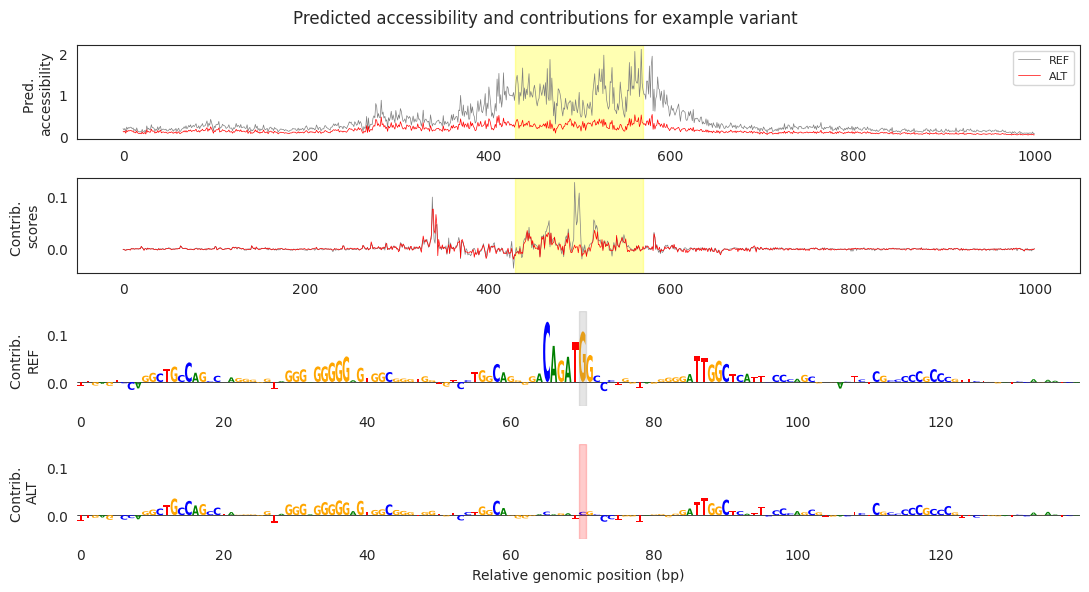

In [111]:
fig, ax = plt.subplots(4, 1, figsize = (11, 6))

alpha = 0.3
contrib_flank = 70

# reshape the predictions
pred_ref = y_ref[0].squeeze()
pred_alt = y_alt[0].squeeze()

# get the attributions in the central 1,000 bp
attr_ref_short = attr_ref.T[(INPUTLEN // 2 - 500):(INPUTLEN // 2 + 500)]
attr_alt_short = attr_alt.T[(INPUTLEN // 2 - 500):(INPUTLEN // 2 + 500)]

# prediction in 1,000 bp
ax[0].plot(pred_ref, linewidth = 0.5, label = "REF", color = "gray")
ax[0].plot(pred_alt, linewidth = 0.5, label = "ALT", color = "red")
ax[0].set_ylabel("Pred. \naccessibility")
ax[0].axvspan(500 - contrib_flank, 500 + contrib_flank, alpha = alpha, color='yellow')
ax[0].legend(fontsize = 8)

# attribution in 1,000 bp
ax[1].plot(attr_ref_short.sum(axis = 1).squeeze(), linewidth = 0.5, label = "REF", color = "gray")
ax[1].plot(attr_alt_short.sum(axis = 1).squeeze(), linewidth = 0.5, label = "ALT", color = "red")
ax[1].set_ylabel("Contrib. \nscores")
ax[1].axvspan(500 - contrib_flank, 500 + contrib_flank, alpha = alpha, color = 'yellow')

# zoomed contribs (REF)
tangermeme.plot.plot_logo(np.float64(attr_ref.squeeze(0)), start = var_pos_input - contrib_flank, end = var_pos_input + contrib_flank, ax=ax[2], ylim = (-0.05, 0.5))
ax[2].set_ylim(-0.05, 0.15)
ax[2].axvspan(contrib_flank - 0.5, contrib_flank + 0.5, alpha = alpha - 0.1, color = 'gray')
ax[2].set_ylabel("Contrib. \nREF")

# zoomed contribs (ALT)
tangermeme.plot.plot_logo(np.float64(attr_alt.squeeze(0)), start = var_pos_input - contrib_flank, end = var_pos_input + contrib_flank, ax=ax[3], ylim = (-0.05, 0.5)),
ax[3].set_ylim(-0.05, 0.15)
ax[3].axvspan(contrib_flank - 0.5, contrib_flank + 0.5, alpha = alpha - 0.1, color = 'red')
ax[3].set_ylabel("Contrib. \nALT")

# put a title at the very top
plt.suptitle("Predicted accessibility and contributions for example variant", fontsize = 12)
plt.xlabel("Relative genomic position (bp)")
plt.tight_layout()

plt.show();